# Model Selection

In this exercise section, we will see some of the methods to select a model in the first place. These includes:

- backward feature selection, which is a supervised methodology to identify the relevant features for a given task;
- regularization with the $\lambda$ parameter of Lasso;
- Hyperparameter tuning of XGBoost and MLP Neural Network.

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
np.random.seed(42)

In [3]:
data_path = "data"

In [4]:
# import the clean data from the previous lesson
station_df = pd.read_excel(os.path.join(data_path, "clean_data.xlsx"), index_col=0)

In [5]:
station_df.head()

,Air Temperature (°C),Ammonium (mg/l),Conductivity (µS/cm),DOC (mg/l),Dissolved Oxygen (mg/l),Nitrate (mg/l),Water Temperature (°C),pH,Flow Rate (m³/s),Cumulated Rainfall (mm)
1986-11-30,6.000000,0.330000,569.500000,9.250000,8.700000,0.550000,7.650000,7.7,54.050000,0.813333
1986-12-31,5.794702,0.272517,567.344371,9.034437,9.254305,0.601325,7.865563,7.7,70.463576,3.570968
1987-01-31,5.589404,0.215033,565.188742,8.818874,9.808609,0.652649,8.081126,7.7,86.877152,1.738710
1987-02-28,5.403974,0.163113,563.241722,8.624172,10.309272,0.699007,8.275828,7.7,101.702318,1.289286
1987-03-31,5.198675,0.105629,561.086093,8.408609,10.863576,0.750331,8.491391,7.7,118.115894,0.858065


## Backward Feature Selection

Let us try to identify a convenient subset of $k$ features for our regression task. In principle, we would have to train $\binom{9}{k}$ models, one for each $k \in \{ 1, ..., 9 \}$, and to compare one model against the others. This sounds quite inefficient. Instead, we start from the complete set of features and we try to iteratively remove the least relevant feature. The relevance of a feature can be specified in different ways. For simple models like linear regression, usually the one with the coefficient with the highest p-value is removed. We stop when there are no features with a p-value > 0.5.

In [6]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [7]:
# split the dataframe into features and target
X = station_df.drop(columns=["DOC (mg/l)"]).copy()
y = station_df["DOC (mg/l)"].copy()

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# revert to dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)

In [8]:
# Let's first train a linear regression model with all the features
X_train_scaled = sm.add_constant(X_train_scaled)

initial_model = sm.OLS(y_train, X_train_scaled).fit()

In [9]:
import numpy as np
import statsmodels.api as sm

def backward_feature_selection(X_bfs, y_bfs):
    features = list(X_bfs.columns)
    best_features = features.copy()
    best_model = None
    best_aic = initial_model.aic

    # while there are features to remove
    while len(features) > 1:
        
        # Initialize the best feature and the current best features
        current_best_features = best_features.copy()

        # for each feature
        for feature in features:
            remaining_features = [f for f in features if f != feature]  # Remove one feature
            X_step = X_bfs[remaining_features]
            X_step = sm.add_constant(X_step)
            model = sm.OLS(y_bfs, X_step).fit()
            aic = model.aic

            # If the AIC of the new model is better, store the new AIC and the new features
            if aic < best_aic:
                best_aic = aic
                # Store the new best features
                best_features = remaining_features
                best_model = model
                removed_feature = feature  # Store the removed feature
            
        # If no feature was removed, stop the loop
        if best_features == current_best_features:
            print("No further improvement in AIC. Stopping.")
            break

        print(f"New best AIC: {best_aic} | Removed feature: {removed_feature}")
        # Update the features to the current best features for the next iteration
        features = best_features.copy()

    return best_features, best_model


In [10]:
selected_features, model = backward_feature_selection(X_train_scaled, y_train)

New best AIC: 1017.8083154862672 | Removed feature: Ammonium (mg/l)
New best AIC: 1016.1574846374177 | Removed feature: Dissolved Oxygen (mg/l)
New best AIC: 1014.6812529689939 | Removed feature: Air Temperature (°C)
No further improvement in AIC. Stopping.


In [11]:
print(f"Selected features: {selected_features}")
print()
print(model.summary())

Selected features: ['const', 'Conductivity (µS/cm)', 'Nitrate (mg/l)', 'Water Temperature (°C)', 'pH', 'Flow Rate (m³/s)', 'Cumulated Rainfall (mm)']

                            OLS Regression Results                            
Dep. Variable:             DOC (mg/l)   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     18.48
Date:                Thu, 06 Feb 2025   Prob (F-statistic):           1.13e-18
Time:                        20:39:20   Log-Likelihood:                -500.34
No. Observations:                 357   AIC:                             1015.
Df Residuals:                     350   BIC:                             1042.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t   

## Regularization

We are going to use Lasso regularization, which is indeed a model selection and feature selection technique, as it adds a $L_1$-norm to the loss function shrinking the coefficients of less important features toward zero. We are going to perform cross validation for a set of values of the regularization term $\lambda$. Note that if $\lambda = 0$, we go back to classic OLS linear regression.

In [12]:
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

In [13]:
# split the dataframe into features and target
X = station_df.drop(columns=["DOC (mg/l)"]).copy()
y = station_df["DOC (mg/l)"].copy()

# split the data into training and testing sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# revert to dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X.columns, index=X_valid.index)

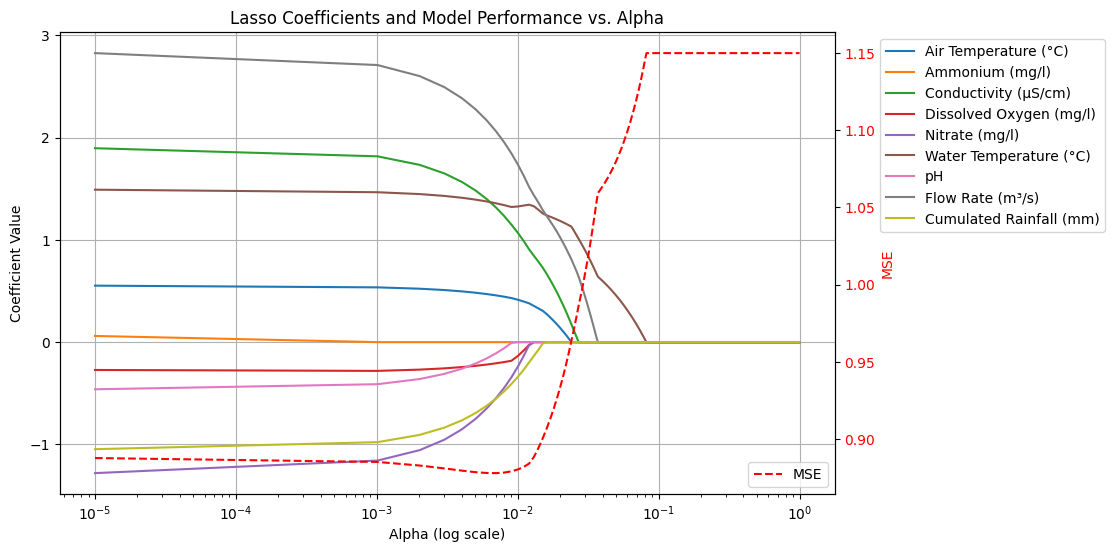

In [14]:
# show how the coefficients change with different lambdas (alphas in sklearn)
# together with the model performance

alphas = np.linspace(1e-5, 1, 1000)
coeffs = []
errors = []

for alpha in alphas:
    model = Lasso(alpha=alpha)
    model.fit(X_train_scaled, y_train)
    coeffs.append(model.coef_)
    errors.append(mean_squared_error(y_valid, model.predict(X_valid_scaled)))
    
coeffs = np.array(coeffs)

fig, ax1 = plt.subplots(figsize=(10, 6))

for i in range(coeffs.shape[1]):
    ax1.plot(alphas, coeffs[:, i], label=model.feature_names_in_[i])
    
ax1.set_xscale("log")
ax1.set_xlabel("Lambda (log scale)")
ax1.set_ylabel("Coefficient Value")
ax1.set_title("Lasso Coefficients and Model Performance vs. Alpha")
ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax1.grid(True)
    
ax2 = ax1.twinx()
ax2.plot(alphas, errors, color="red", linestyle="dashed", label="MSE")
ax2.set_ylabel("MSE", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.legend(loc="lower right")
    
plt.show()


We can see that as alpha increases, coefficients shrink to zero, leading to a too much simple model, where only the constant term is left, meaning that we get a constant mse. When alpha is small, many coefficients retain their magnitude. When alpha reaches 10-3, coefficients start to shrink and around alpha = 10-2 a subset of features has a coefficient close to zero, meaning that Lasso is performing feature selection. We can also see that we have a slight decrease of the MSE, meaning that Lasso feature selection is leading to a better representation of the relationship between the target and features variable.

## Hyperparameter Tuning

Hyperparameter tuning is the process of finding the optimal values for a model’s hyperparameters, which are parameters that are not learned directly from the data but rather set before training. These hyperparameters control how the model learns and generalizes.

We are going to see two simple techniques, Grid Search (systematically evaluates predefined hyperparameter values) and Random Search (samples random combinations within a given range), but more sophisticated ones can also be used, such as [Bayesian Optimization](https://en.wikipedia.org/wiki/Bayesian_optimization#:~:text=Bayesian%20optimization%20is%20a%20sequential,expensive%2Dto%2Devaluate%20functions.) or frameworks like [Optuna](https://optuna.readthedocs.io/en/stable/).

The models we are going to tune are MLP Neural Network and XGBoost. We use the scikit-learn package which offers both Grid Search and Random Search. For further information, [GridSearchCV](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) and [RandomSearchCV](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV).

Hyperparameter tuning is usually performed with cross-validation in order to ensure that the selected hyperparameters generalize well on unseen data.

In [15]:
# import necessary libraries
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [16]:
# split the dataframe into features and target
X = station_df.drop(columns=["DOC (mg/l)"]).copy()
y = station_df["DOC (mg/l)"].copy()

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# revert to dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

### Neural Network

Each neuron in the neural network is characterized by an activation function which is a transformation of its input. Different activation functions are present. The most used are usually:

- ReLU (Rectified Linear Unit)
- Tanh
- Sigmoid

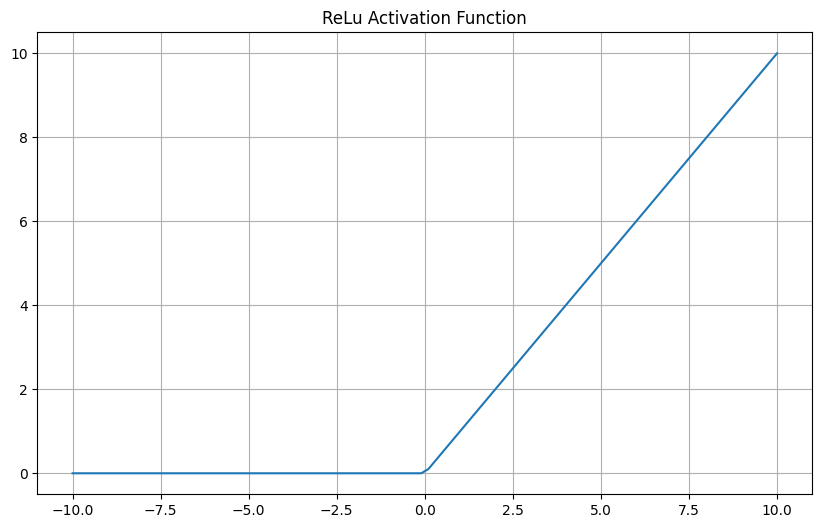

In [17]:
# ReLu activation function

x = np.linspace(-10, 10, 100)
y = np.maximum(0, x)

plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.title("ReLu Activation Function")
plt.grid(True)
plt.show()

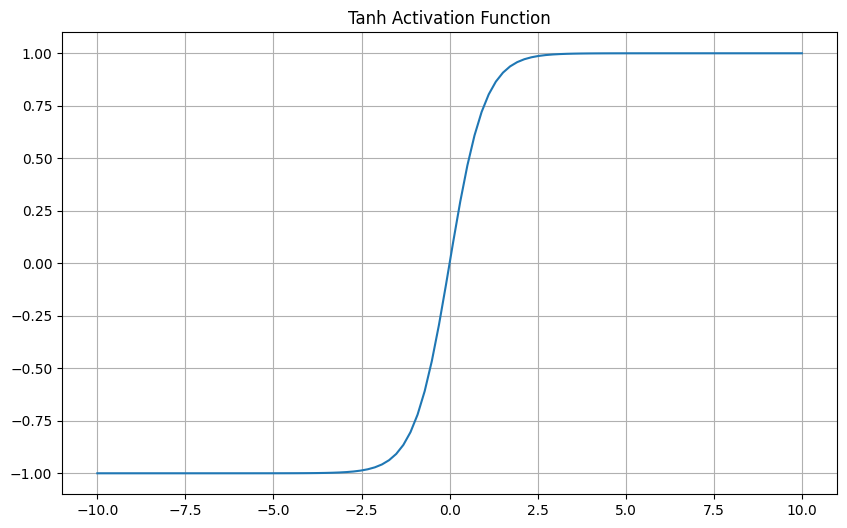

In [18]:
# Tanh activation function

x = np.linspace(-10, 10, 100)
y = np.tanh(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.title("Tanh Activation Function")
plt.grid(True)
plt.show()

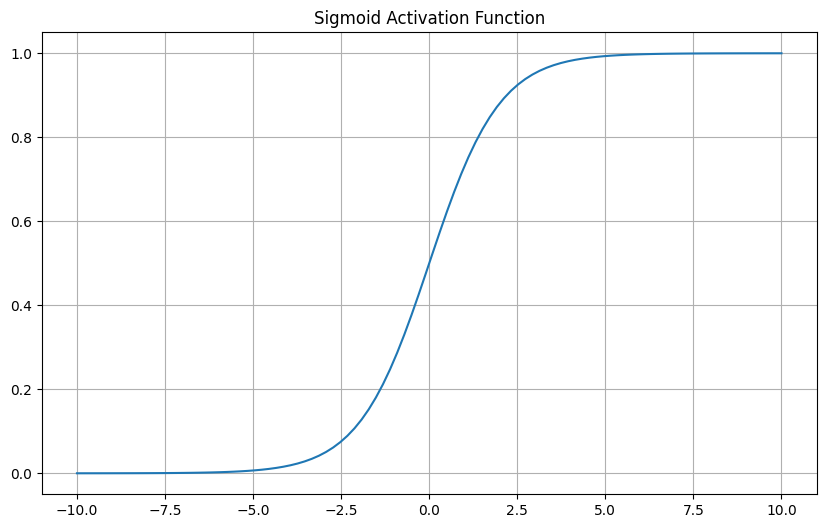

In [19]:
# Sigmoid activation function

x = np.linspace(-10, 10, 100)
y = 1 / (1 + np.exp(-x))

plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.title("Sigmoid Activation Function")
plt.grid(True)
plt.show()

In [20]:
# we are going to define the hyperparameters to search and their ranges of values
# since there are a lof of hyperparameters, we just define a few of them

mlp_params = {
    "hidden_layer_sizes": [(20,), (50,) , (20, 20), (50, 50)], # number of neurons in each layer
    "activation": ["relu", "logistic", "tanh" ], # activation function
    "solver": ["adam", "sgd"], # optimization algorithm
    "learning_rate": ["constant", "adaptive"], # learning rate schedule
    "batch_size": [16, 32,], # size of minibatches
}

#### Grid Search

In [21]:
estimator = MLPRegressor(max_iter=1000)

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=mlp_params,
    cv=5,
    scoring="neg_mean_squared_error", # we want to minimize the MSE
    verbose=3, # change to higher values to see more information
)

In [22]:
# this could take a couple of minutes
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5] END activation=relu, batch_size=16, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam;, score=-2.551 total time=   1.1s
[CV 2/5] END activation=relu, batch_size=16, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam;, score=-1.446 total time=   1.0s
[CV 3/5] END activation=relu, batch_size=16, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam;, score=-0.775 total time=   0.8s
[CV 4/5] END activation=relu, batch_size=16, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam;, score=-0.576 total time=   0.9s
[CV 5/5] END activation=relu, batch_size=16, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam;, score=-0.732 total time=   0.7s
[CV 1/5] END activation=relu, batch_size=16, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd;, score=-2.890 total time=   0.6s
[CV 2/5] END activation=relu, batch_size=16, hidden_layer_sizes=(20,), learning_rate=constant

c:\Users\beaca\OneDrive\Documenti\Repository_Corso_PhD_GitHub\ml-practical-sessions\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd;, score=-2.557 total time=   1.4s
[CV 2/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd;, score=-1.777 total time=   0.8s


c:\Users\beaca\OneDrive\Documenti\Repository_Corso_PhD_GitHub\ml-practical-sessions\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd;, score=-0.628 total time=   1.4s
[CV 4/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd;, score=-0.562 total time=   1.4s
[CV 5/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd;, score=-0.942 total time=   0.9s
[CV 1/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam;, score=-2.840 total time=   1.4s
[CV 2/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam;, score=-1.752 total time=   1.2s
[CV 3/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam;, score=-0.717 total time=   1.3s
[CV 4/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam;, score=-0.542 total t

c:\Users\beaca\OneDrive\Documenti\Repository_Corso_PhD_GitHub\ml-practical-sessions\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=-2.552 total time=   1.4s
[CV 2/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=-1.808 total time=   1.3s


c:\Users\beaca\OneDrive\Documenti\Repository_Corso_PhD_GitHub\ml-practical-sessions\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=-0.631 total time=   1.4s
[CV 4/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=-0.556 total time=   1.3s
[CV 5/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=-0.891 total time=   1.2s
[CV 1/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam;, score=-2.873 total time=   1.2s
[CV 2/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam;, score=-1.721 total time=   1.2s
[CV 3/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam;, score=-0.690 total time=   1.2s
[CV 4/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam;, score=-0.532 total t

c:\Users\beaca\OneDrive\Documenti\Repository_Corso_PhD_GitHub\ml-practical-sessions\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd;, score=-2.560 total time=   2.0s
[CV 2/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd;, score=-1.826 total time=   1.1s


c:\Users\beaca\OneDrive\Documenti\Repository_Corso_PhD_GitHub\ml-practical-sessions\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd;, score=-0.616 total time=   2.1s
[CV 4/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd;, score=-0.758 total time=   0.0s
[CV 5/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd;, score=-0.973 total time=   1.0s
[CV 1/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam;, score=-2.881 total time=   1.2s
[CV 2/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam;, score=-1.796 total time=   1.3s
[CV 3/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam;, score=-0.705 total time=   1.4s
[CV 4/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam;, score=-0.544 total t

c:\Users\beaca\OneDrive\Documenti\Repository_Corso_PhD_GitHub\ml-practical-sessions\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd;, score=-2.515 total time=   2.1s
[CV 2/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd;, score=-1.873 total time=   1.4s


c:\Users\beaca\OneDrive\Documenti\Repository_Corso_PhD_GitHub\ml-practical-sessions\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd;, score=-0.589 total time=   2.1s
[CV 4/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd;, score=-0.626 total time=   1.0s
[CV 5/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd;, score=-0.978 total time=   1.2s
[CV 1/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(20, 20), learning_rate=constant, solver=adam;, score=-2.701 total time=   0.3s
[CV 2/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(20, 20), learning_rate=constant, solver=adam;, score=-1.958 total time=   0.2s
[CV 3/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(20, 20), learning_rate=constant, solver=adam;, score=-0.608 total time=   0.3s
[CV 4/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(20, 20), learning_rate=constant, solver=adam;, score=-0

c:\Users\beaca\OneDrive\Documenti\Repository_Corso_PhD_GitHub\ml-practical-sessions\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(20, 20), learning_rate=constant, solver=sgd;, score=-0.562 total time=   2.2s
[CV 4/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(20, 20), learning_rate=constant, solver=sgd;, score=-0.775 total time=   0.1s
[CV 5/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(20, 20), learning_rate=constant, solver=sgd;, score=-0.992 total time=   0.1s
[CV 1/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(20, 20), learning_rate=adaptive, solver=adam;, score=-2.689 total time=   0.2s
[CV 2/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(20, 20), learning_rate=adaptive, solver=adam;, score=-1.950 total time=   0.3s
[CV 3/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(20, 20), learning_rate=adaptive, solver=adam;, score=-0.610 total time=   0.3s
[CV 4/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(20, 20), learning_rate=adaptive, solver=adam;,

c:\Users\beaca\OneDrive\Documenti\Repository_Corso_PhD_GitHub\ml-practical-sessions\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, batch_size=32, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam;, score=-3.203 total time=   1.4s
[CV 2/5] END activation=tanh, batch_size=32, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam;, score=-1.724 total time=   0.8s
[CV 3/5] END activation=tanh, batch_size=32, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam;, score=-0.792 total time=   0.8s
[CV 4/5] END activation=tanh, batch_size=32, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam;, score=-0.576 total time=   0.6s
[CV 5/5] END activation=tanh, batch_size=32, hidden_layer_sizes=(20,), learning_rate=constant, solver=adam;, score=-0.678 total time=   0.9s
[CV 1/5] END activation=tanh, batch_size=32, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd;, score=-2.896 total time=   0.5s
[CV 2/5] END activation=tanh, batch_size=32, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd;, score=-1.617 total time=   0.4s
[CV 3/5] END ac

GridSearchCV(cv=5, estimator=MLPRegressor(max_iter=1000),
             param_grid={'activation': ['relu', 'logistic', 'tanh'],
                         'batch_size': [16, 32],
                         'hidden_layer_sizes': [(20,), (50,), (20, 20),
                                                (50, 50)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['adam', 'sgd']},
             scoring='neg_mean_squared_error', verbose=3)

In [23]:
import pprint

# print the results of the best model found
print("The best parameters are:")
pprint.pprint(grid_search.best_params_)
print()
print(f"The best score is: {-grid_search.best_score_.round(3)}")

The best parameters are:
{'activation': 'relu',
 'batch_size': 16,
 'hidden_layer_sizes': (20,),
 'learning_rate': 'constant',
 'solver': 'adam'}

The best score is: 1.216


#### Random Search

In [24]:
estimator = MLPRegressor(max_iter=1000)

random_search = RandomizedSearchCV(
    n_iter=10,
    estimator=estimator,
    param_distributions=mlp_params,
    cv=5,
    scoring="neg_mean_squared_error", # we want to minimize the MSE
    verbose=3, # change to higher values to see more information
)

In [25]:
random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END activation=logistic, batch_size=16, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam;, score=-3.577 total time=   2.2s
[CV 2/5] END activation=logistic, batch_size=16, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam;, score=-1.725 total time=   2.3s
[CV 3/5] END activation=logistic, batch_size=16, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam;, score=-0.692 total time=   2.6s
[CV 4/5] END activation=logistic, batch_size=16, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam;, score=-0.528 total time=   2.5s
[CV 5/5] END activation=logistic, batch_size=16, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam;, score=-0.739 total time=   2.6s
[CV 1/5] END activation=tanh, batch_size=32, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam;, score=-2.855 total time=   1.0s
[CV 2/5] END activation=tanh, batch_size=32, hidden_layer_

c:\Users\beaca\OneDrive\Documenti\Repository_Corso_PhD_GitHub\ml-practical-sessions\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd;, score=-2.521 total time=   2.3s
[CV 2/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd;, score=-1.905 total time=   0.9s


c:\Users\beaca\OneDrive\Documenti\Repository_Corso_PhD_GitHub\ml-practical-sessions\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd;, score=-0.607 total time=   2.8s
[CV 4/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd;, score=-0.581 total time=   1.6s
[CV 5/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd;, score=-0.996 total time=   0.8s
[CV 1/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam;, score=-2.674 total time=   0.1s
[CV 2/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam;, score=-1.979 total time=   0.1s
[CV 3/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam;, score=-0.609 total time=   0.2s
[CV 4/5] END activation=logistic, batch_size=32, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam;, score=-0

RandomizedSearchCV(cv=5, estimator=MLPRegressor(max_iter=1000),
                   param_distributions={'activation': ['relu', 'logistic',
                                                       'tanh'],
                                        'batch_size': [16, 32],
                                        'hidden_layer_sizes': [(20,), (50,),
                                                               (20, 20),
                                                               (50, 50)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'solver': ['adam', 'sgd']},
                   scoring='neg_mean_squared_error', verbose=3)

In [26]:
# print the results of the best model found
print("The best parameters are:")
pprint.pprint(random_search.best_params_)
print()
print(f"The best score is: {-random_search.best_score_.round(3)}")

The best parameters are:
{'activation': 'relu',
 'batch_size': 32,
 'hidden_layer_sizes': (20,),
 'learning_rate': 'adaptive',
 'solver': 'sgd'}

The best score is: 1.264


### XGBoost

In [27]:
# we are going to use tree-based models
xgb_params = {
    "n_estimators": [20, 50, 100], # number of trees
    "eta": [0.01, 0.1, 0.3, 0.5, 0.7], # learning rate
    "max_depth": [3, 5, 7], # maximum depth of the trees\
}

#### Grid Search

In [28]:
estimator = XGBRegressor()

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=xgb_params,
    cv=5,
    scoring="neg_mean_squared_error", # we want to minimize the MSE
    verbose=3, # change to higher values to see more information
)

In [29]:
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV 1/5] END eta=0.01, max_depth=3, n_estimators=20;, score=-2.698 total time=   0.0s
[CV 2/5] END eta=0.01, max_depth=3, n_estimators=20;, score=-1.917 total time=   0.0s
[CV 3/5] END eta=0.01, max_depth=3, n_estimators=20;, score=-0.581 total time=   0.0s
[CV 4/5] END eta=0.01, max_depth=3, n_estimators=20;, score=-0.727 total time=   0.0s
[CV 5/5] END eta=0.01, max_depth=3, n_estimators=20;, score=-0.968 total time=   0.0s
[CV 1/5] END eta=0.01, max_depth=3, n_estimators=50;, score=-2.684 total time=   0.0s
[CV 2/5] END eta=0.01, max_depth=3, n_estimators=50;, score=-1.868 total time=   0.0s
[CV 3/5] END eta=0.01, max_depth=3, n_estimators=50;, score=-0.564 total time=   0.0s
[CV 4/5] END eta=0.01, max_depth=3, n_estimators=50;, score=-0.672 total time=   0.0s
[CV 5/5] END eta=0.01, max_depth=3, n_estimators=50;, score=-0.922 total time=   0.0s
[CV 1/5] END eta=0.01, max_depth=3, n_estimators=100;, score=-2.649 total time

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'eta': [0.01, 0.1, 0.3, 0.5, 0.7],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [20, 50, 100]},
             scoring='neg_mean_squared_error', verbose=3)

In [30]:
# print the results of the best model found
print("The best parameters are:")
pprint.pprint(grid_search.best_params_)
print()
print(f"The best score is: {-grid_search.best_score_.round(3)}")

The best parameters are:
{'eta': 0.1, 'max_depth': 7, 'n_estimators': 20}

The best score is: 1.288


#### Random Search

In [31]:
random_search = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=xgb_params,
    cv=5,
    scoring="neg_mean_squared_error", # we want to minimize the MSE
    verbose=3, # change to higher values to see more information
)

In [32]:
random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END eta=0.01, max_depth=3, n_estimators=20;, score=-2.698 total time=   0.0s
[CV 2/5] END eta=0.01, max_depth=3, n_estimators=20;, score=-1.917 total time=   0.0s
[CV 3/5] END eta=0.01, max_depth=3, n_estimators=20;, score=-0.581 total time=   0.0s
[CV 4/5] END eta=0.01, max_depth=3, n_estimators=20;, score=-0.727 total time=   0.0s
[CV 5/5] END eta=0.01, max_depth=3, n_estimators=20;, score=-0.968 total time=   0.0s
[CV 1/5] END eta=0.1, max_depth=7, n_estimators=50;, score=-2.784 total time=   0.0s
[CV 2/5] END eta=0.1, max_depth=7, n_estimators=50;, score=-1.778 total time=   0.0s
[CV 3/5] END eta=0.1, max_depth=7, n_estimators=50;, score=-0.833 total time=   0.0s
[CV 4/5] END eta=0.1, max_depth=7, n_estimators=50;, score=-0.552 total time=   0.0s
[CV 5/5] END eta=0.1, max_depth=7, n_estimators=50;, score=-0.727 total time=   0.0s
[CV 1/5] END eta=0.3, max_depth=7, n_estimators=50;, score=-3.034 total time=   0.0s

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   param_distributions={'eta': [0.01, 0.1, 0.3, 0.5, 0.7],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [20, 50, 100]},
                   scoring='neg_mean_squared_error', verbose=3)

In [33]:
# print the results of the best model found
print("The best parameters are:")
pprint.pprint(random_search.best_params_)
print()
print(f"The best score is: {-random_search.best_score_.round(3)}")

The best parameters are:
{'eta': 0.3, 'max_depth': 3, 'n_estimators': 20}

The best score is: 1.297


We can see that grid search evaluates every possible combination of parameters' values given, while random search just a subset. The trade-off is that with grid search, the combination with the smallest error will be surely found but the computation time will be much higher with respect to random search as it is basically a brute-forcing technique.